# UFO Sightings
## Motivation
Our dataset is a collection of ufo sightings maintained by the __National UFO Reporting Center__ foundation since 1998, even though the first recorded data going back until 1906. In particular, for every sighting we have data about: the geographical localization, datetime, duration of the sighting, shape of the object and a brief comment of the situation.
We chose this dataset because we find it curious and from some points of view fun to work with, recently (march 2025) in the european skys a [bright blue spiral appeared](https://www.bbc.com/news/articles/c241073v66jo) reopening the debate on the theme. Also we were intrested in working in less clean dataset, as an online form report is, to work more directly with people behaviour and perception of the phenomenon. We were also interested in learing more about natural language processing models, performing an analysis also in the open comment section of the dataset.
The final goal of this report is presenting the situation of ufo sightings to the reader, firstly by a general descritpion of the dataset that we analyzied, then a focus part on a sentiment analysis of the reporters and in conclusion a comparison between debunkers and ufo believers.
## Basic statistics
As previously highlighted, since the dataset is coming from an online form, with data inserted directly by users, we weren't surprised in finding some incongruences and some unsanitized data. As a first activity, we fixed some writing errors in the dataset, such as random characters in numeric fields (ex. a value of latitude _33q.200088_ or a value of duration _8'_). In addition we found the following incongruences:
- The colums duration (seconds) and (hours/min) sometimes contain different values. We decided to analyze only data in seconds, since they are more standardized and comparable between themself, whereas hours/min are in some cases more vague (ex. 1/2 hours) and unstandardized (ex. _5 minutes_ vs _5 min. 7 sec_ vs _several minutes_ etc.).
- Some row contain a value of date posted anterior to the sighting datetime, we interpreted this as an error in the report instead of a prediction of the future, so in these rows we switch the two values.
Furthermore, we group the shape described by the reporters in a more precise set of cathegories, for a better classification.
Eventually, we found a lot of missing and inconsistent values in city, state and country fields, so we decided to ignore these values and to use only latitude and longitude for geolocalization.

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dataset = pd.read_csv('ufo_sightings_scrubbed.csv', dtype={
    'datetime': str,
    'city': str,
    'state': str,
    'country': str,
    'shape': str,
    'duration (seconds)': float,
    'duration (hours/min)': str,
    'comments': str,
    'date posted': str,
    'latitude': float,
    'longitude': float
})
dataset['datetime'] = pd.to_datetime(dataset['datetime'])
dataset['date posted'] = pd.to_datetime(dataset['date posted'])
# Drop unnecessary columns
dataset.drop(columns=['city', 'state', 'country', 'duration (hours/min)'], inplace=True)
# Rename colum duration (seconds) to duration
dataset.rename(columns={'duration (seconds)': 'duration'}, inplace=True)

# Swap datetime and date posted if datetime is greater than date posted
mask = dataset['datetime'].dt.date > dataset['date posted'].dt.date
dataset.loc[mask, ['datetime', 'date posted']] = dataset.loc[mask, ['date posted', 'datetime']].values

# Shape mapping
shape_mapping = {
    'cylinder': 'cylinder',
    'light': 'flash',
    'circle': 'disk',
    'sphere': 'sphere',
    'disk': 'disk',
    'fireball': 'fireball',
    'unknown': 'unknown',
    'oval': 'oval',
    'other': 'other',
    'cigar': 'cylinder',
    'rectangle': 'rectangle',
    'chevron': 'chevron',
    'triangle': 'triangle',
    'formation': 'formation',
    np.nan: 'unknown',
    'delta': 'triangle',
    'changing': 'changing',
    'egg': 'oval',
    'diamond': 'diamond',
    'flash': 'flash',
    'teardrop': 'teardrop',
    'cone': 'cone',
    'cross': 'cross',
    'pyramid': 'other',
    'round': 'disk',
    'crescent': 'changing',
    'flare': 'flash',
    'hexagon': 'other',
    'dome': 'other',
    'changed': 'changing'
}
dataset['shape'] = dataset['shape'].str.lower().map(shape_mapping)

# Remove incomplete year (2014)
dataset = dataset[dataset['datetime'].dt.year != 2014]


## Data analysis

Temporal patterns: year distribution, month distribution, day of the week and time during the day

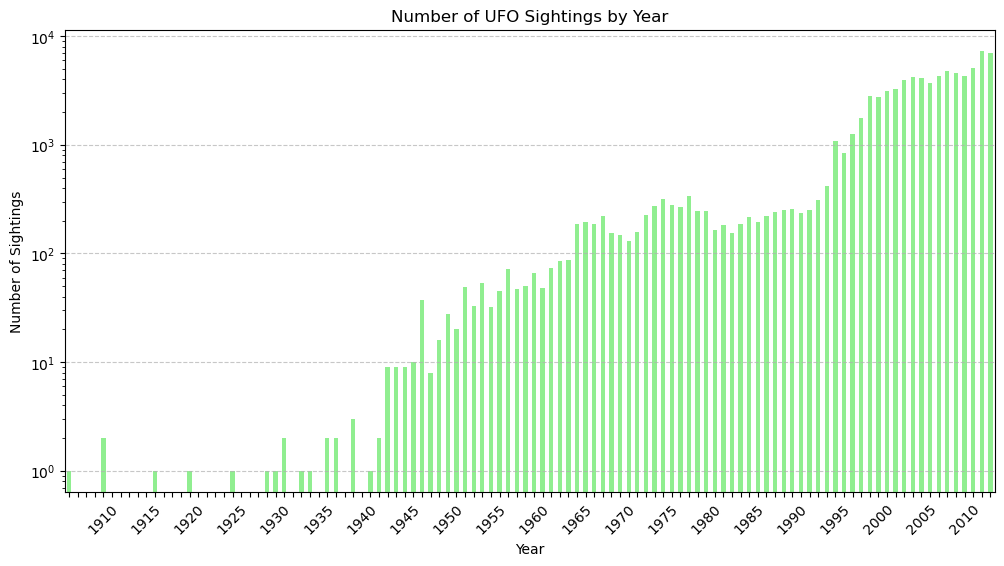

In [110]:
year_count = dataset['datetime'].dt.year.value_counts().sort_index()
all_years = pd.Series(0, index=np.arange(dataset['datetime'].dt.year.min(), dataset['datetime'].dt.year.max()))
year_count = all_years.add(year_count, fill_value=0)
year_count.plot(kind='bar', figsize=(12, 6), color='lightgreen', logy=True)
plt.title('Number of UFO Sightings by Year')
plt.xlabel('Year')
plt.ylabel('Number of Sightings')
plt.grid(axis='y', linestyle='--', alpha=0.7)

years = year_count.index
tick_locs = np.arange(len(years))
tick_labels = [str(year) if year % 5 == 0 else '' for year in years]

plt.xticks(tick_locs, tick_labels, rotation=45)
plt.show()

In the plot above is represented the amount of sigthings per year, without surprise, the trend is in exponential increase (note the log-scale on the y-axis). However is important to highlight that, as shown in the plot below, the webform collect data only from 1998: this means that probably the number of sigthings before that year is underestimated, and the data is made of personal archive of passionate sigthers. Also the low usage of internet in early 2000s can lead to an underestimation of the phenomenon.

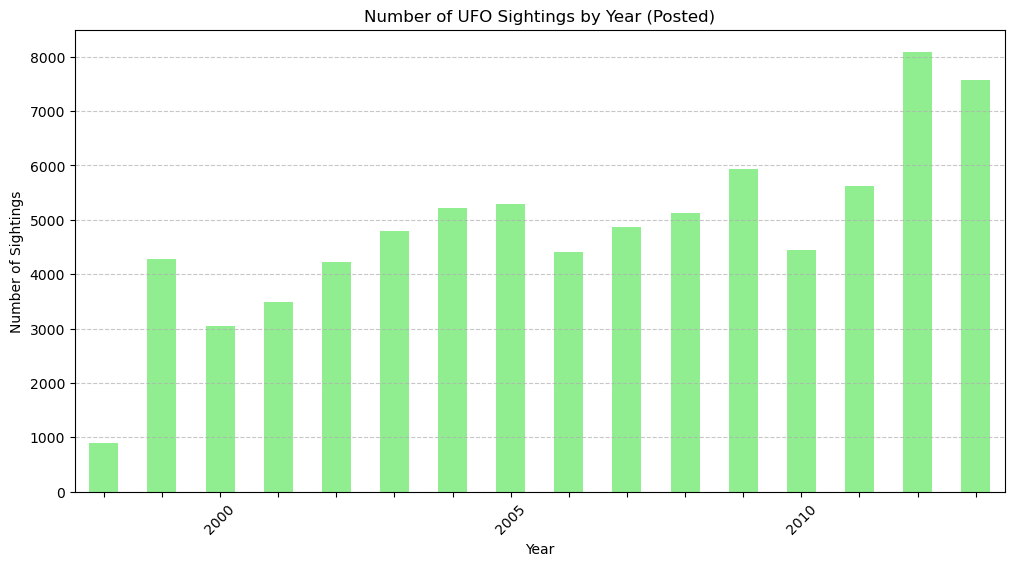

In [111]:
year_count = dataset['date posted'].dt.year.value_counts().sort_index()
all_years = pd.Series(0, index=np.arange(dataset['date posted'].dt.year.min(), dataset['date posted'].dt.year.max()))
year_count = all_years.add(year_count[:-1], fill_value=0)
year_count.plot(kind='bar', figsize=(12, 6), color='lightgreen')
plt.title('Number of UFO Sightings by Year (Posted)')
plt.xlabel('Year')
plt.ylabel('Number of Sightings')
plt.grid(axis='y', linestyle='--', alpha=0.7)

years = year_count.index
tick_locs = np.arange(len(years))
tick_labels = [str(year) if year % 5 == 0 else '' for year in years]

plt.xticks(tick_locs, tick_labels, rotation=45)
plt.show()

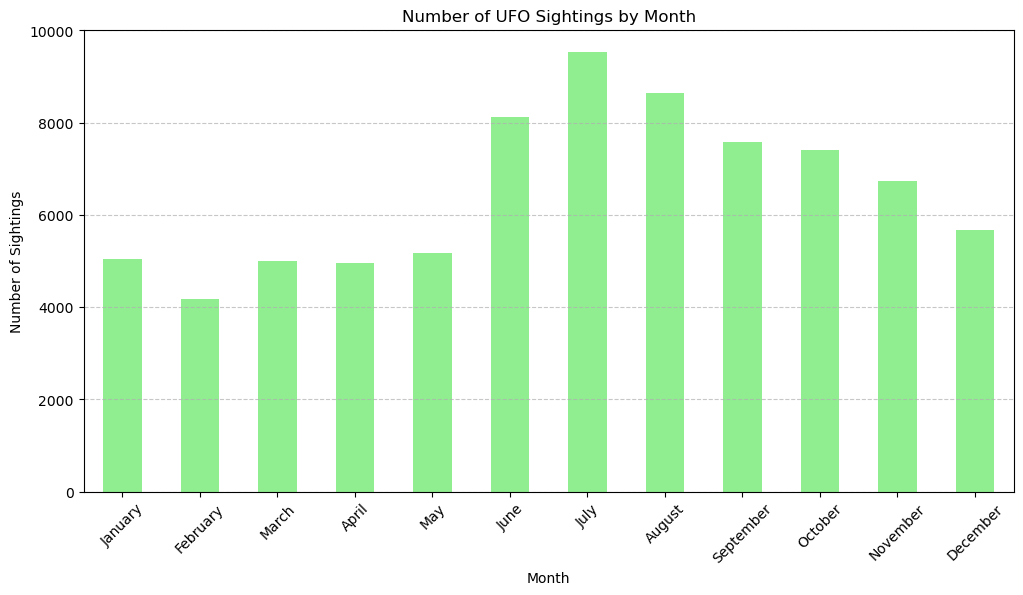

In [112]:
month_count = dataset['datetime'].dt.month.value_counts().sort_index()
month_count.plot(kind='bar', figsize=(12, 6), color='lightgreen')
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
plt.xticks(ticks=np.arange(12), labels=month_names, rotation=45)
plt.title('Number of UFO Sightings by Month')
plt.xlabel('Month')
plt.ylabel('Number of Sightings')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Looking into a monthly subdivision, the summer months (June, July and August) are clearly more popular for UFO sigthings and on the opposite side the lowest values are during winter months (Februray on top of all). _A possible explanation could be the higher amount of time spent outside_.
This pattern is not observable for southern hemisphere sigthings, due to the lower amount of data in comparison to the northern one.

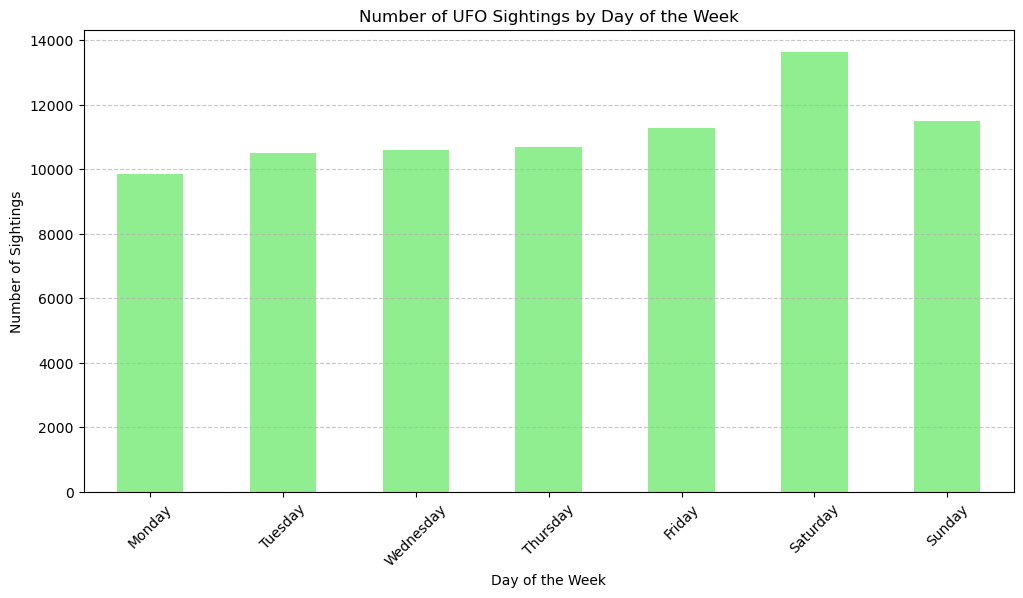

In [113]:
day_of_week_count = dataset['datetime'].dt.dayofweek.value_counts().sort_index()
day_of_week_count.plot(kind='bar', figsize=(12, 6), color='lightgreen')
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.xticks(ticks=np.arange(7), labels=day_names, rotation=45)
plt.title('Number of UFO Sightings by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Sightings')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Similarly, in day of week subdivision, there is a small increase of sighthings during weekend. _Again with high probability because people have more free time for looking at UFOs._

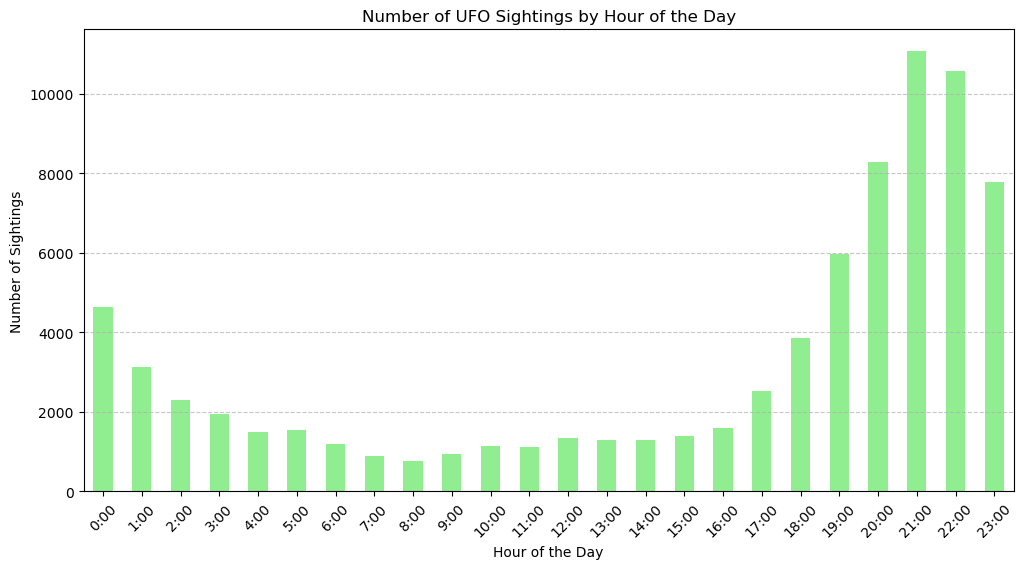

In [114]:
time_of_day_count = dataset['datetime'].dt.hour.value_counts().sort_index()
time_of_day_count.plot(kind='bar', figsize=(12, 6), color='lightgreen')
time_labels = [f'{hour}:00' for hour in range(24)]
plt.xticks(ticks=np.arange(24), labels=time_labels, rotation=45)
plt.title('Number of UFO Sightings by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Sightings')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In the plot above there is a clear unbalance in the hour of the day of UFO sigthings. Note that each sigthing is saved with the time-zone of its location, so a normalisation of the hours was not needed. _Not a clear explanation, probably because the majority of people look at the sky in the evening?_

shape categories

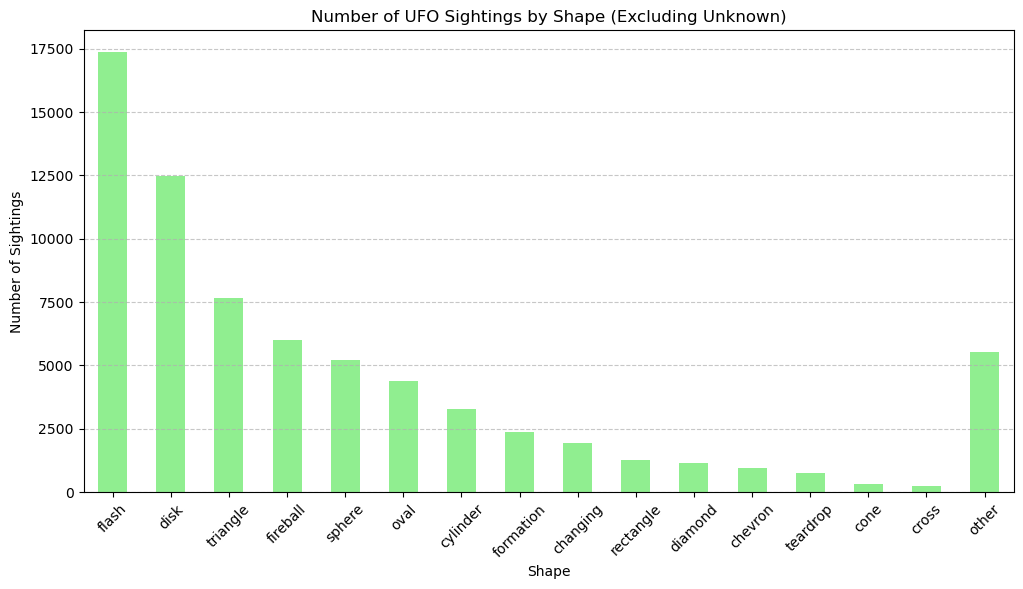

In [115]:
shape_counts = dataset['shape'].value_counts()
shape_counts = shape_counts[shape_counts.index != 'unknown']  # Exclude 'unknown' category
# Move 'other' to the end
shape_counts = shape_counts.reindex(
    [shape for shape in shape_counts.index if shape != 'other'] + ['other']
)
shape_counts.plot(kind='bar', figsize=(12, 6), color='lightgreen')
plt.title('Number of UFO Sightings by Shape (Excluding Unknown)')
plt.xlabel('Shape')
plt.ylabel('Number of Sightings')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

The data has a high amount of flash and disk sigthings. Then more detailed shapes were recorded.

sigthing durations

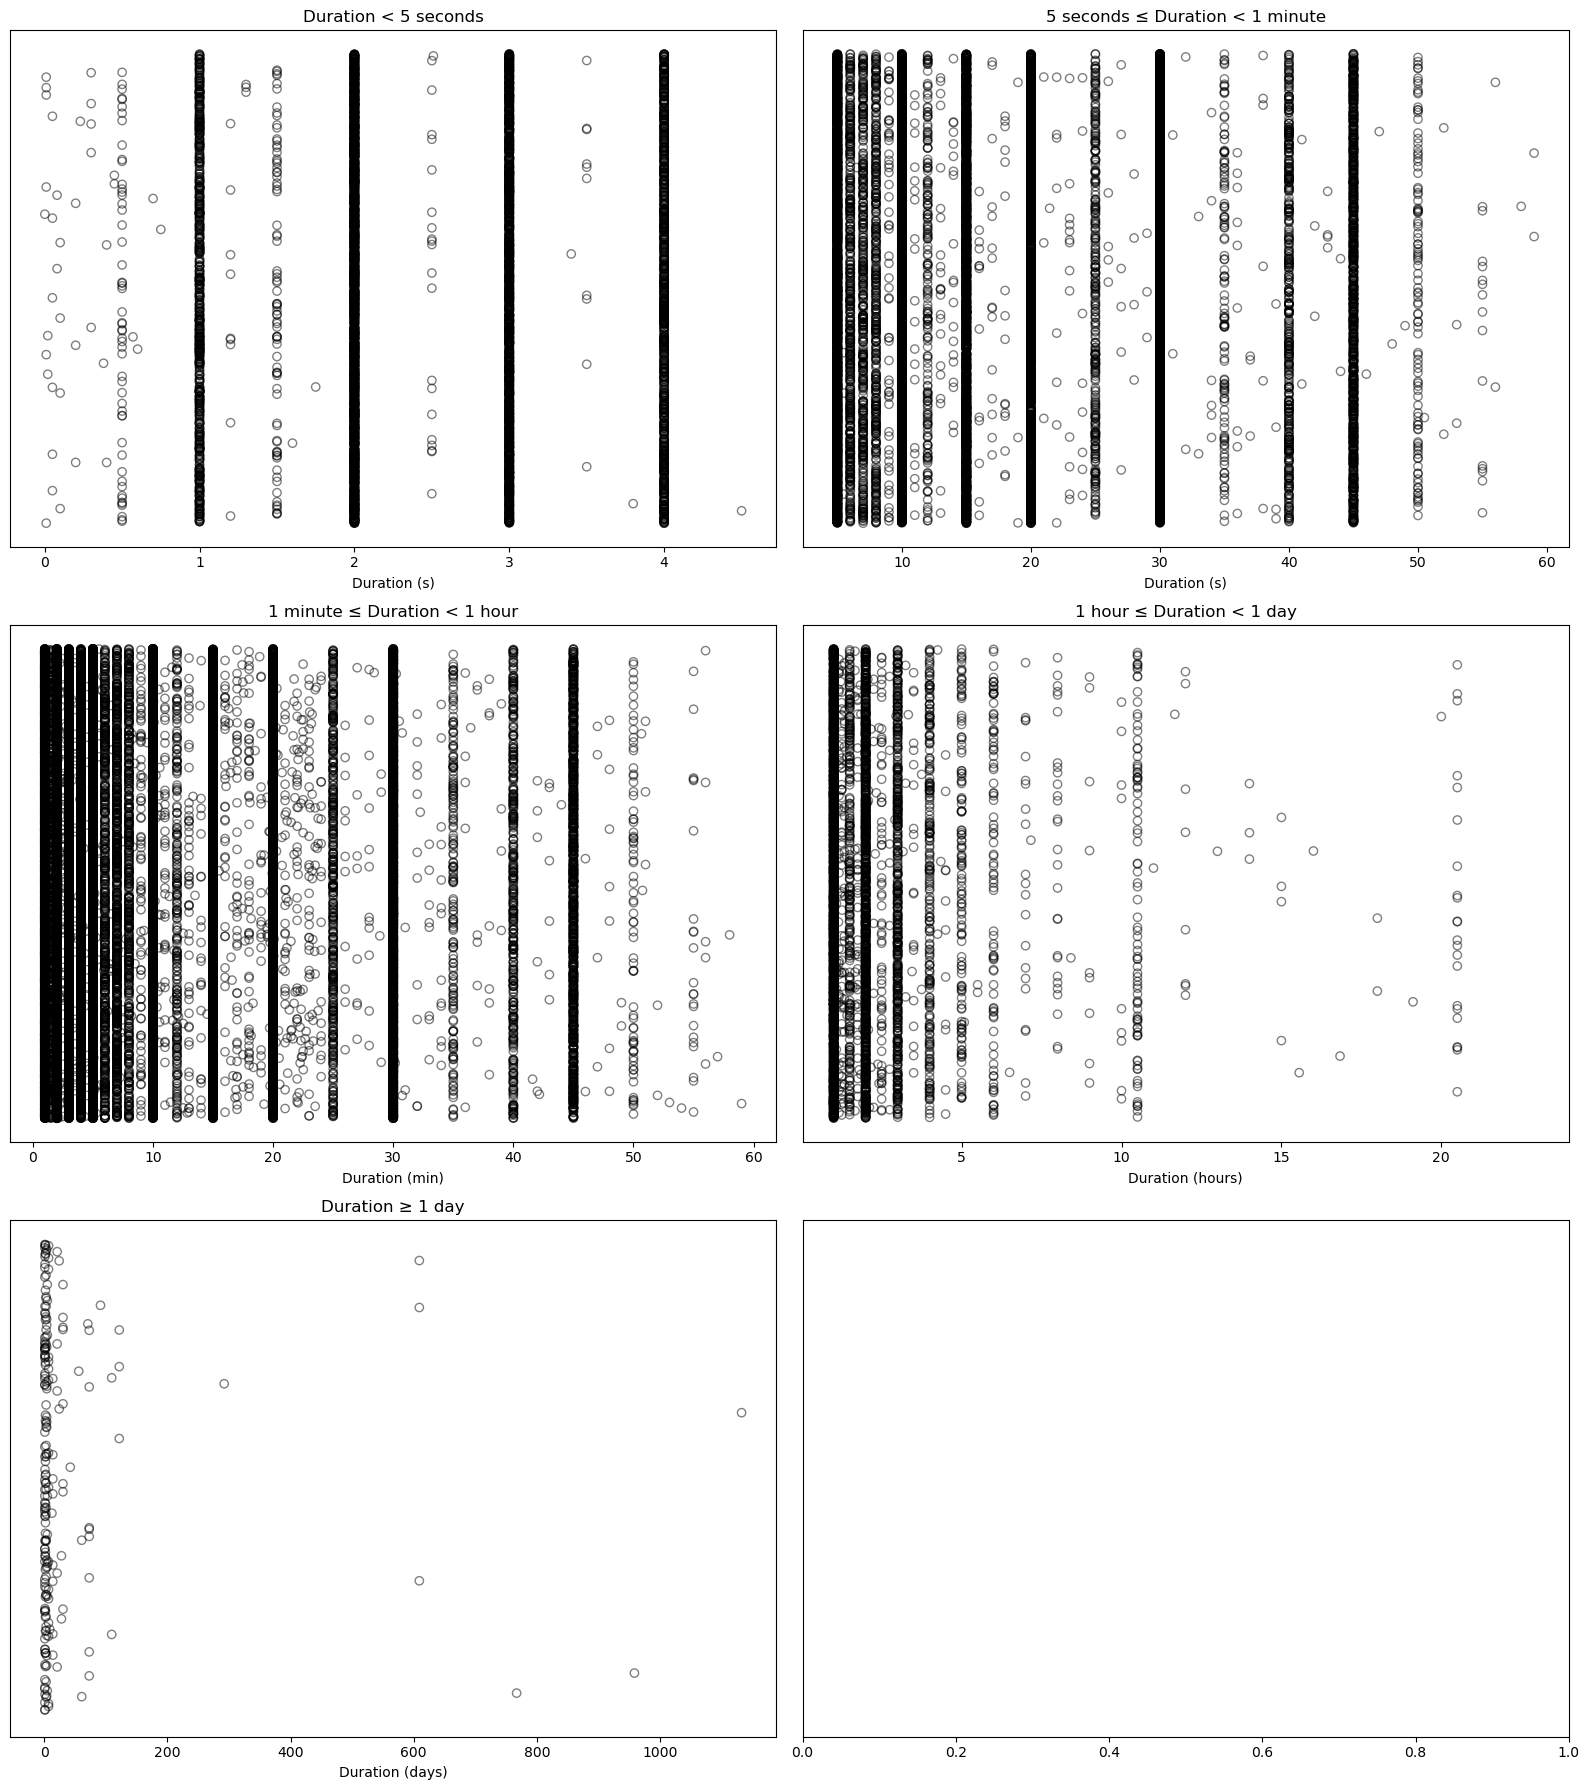

In [116]:
fig, axes = plt.subplots(3, 2, figsize=(16, 18), sharey=True)

# Filter data for each range
less_than_5s = dataset[dataset['duration'] < 5]
between_5s_1m = dataset[(dataset['duration'] >= 5) & (dataset['duration'] < 60)]
between_1m_1h = dataset[(dataset['duration'] >= 60) & (dataset['duration'] < 3600)]
between_1h_1d = dataset[(dataset['duration'] >= 3600) & (dataset['duration'] < 86400)]
greater_than_1d = dataset[dataset['duration'] >= 86400]

# Plot each range
axes[0, 0].scatter(less_than_5s['duration'], [np.random.random() for _ in range(len(less_than_5s))], 
                   alpha=0.5, facecolors='none', edgecolors='black')
axes[0, 0].set_title('Duration < 5 seconds')
axes[0, 0].set_xlabel('Duration (s)')
axes[0, 0].set_yticks([])

axes[0, 1].scatter(between_5s_1m['duration'], [np.random.random() for _ in range(len(between_5s_1m))], 
                   alpha=0.5, facecolors='none', edgecolors='black')
axes[0, 1].set_title('5 seconds ≤ Duration < 1 minute')
axes[0, 1].set_xlabel('Duration (s)')
axes[0, 1].set_yticks([])

axes[1, 0].scatter(between_1m_1h['duration'] / 60, [np.random.random() for _ in range(len(between_1m_1h))], 
                   alpha=0.5, facecolors='none', edgecolors='black')
axes[1, 0].set_title('1 minute ≤ Duration < 1 hour')
axes[1, 0].set_xlabel('Duration (min)')
axes[1, 0].set_yticks([])

axes[1, 1].scatter(between_1h_1d['duration'] / 3600, [np.random.random() for _ in range(len(between_1h_1d))], 
                   alpha=0.5, facecolors='none', edgecolors='black')
axes[1, 1].set_title('1 hour ≤ Duration < 1 day')
axes[1, 1].set_xlabel('Duration (hours)')
axes[1, 1].set_xlim(right=23.99)
axes[1, 1].set_yticks([])

axes[2, 0].scatter(greater_than_1d['duration'] / 86400, [np.random.random() for _ in range(len(greater_than_1d))], 
                   alpha=0.5, facecolors='none', edgecolors='black')
axes[2, 0].set_title('Duration ≥ 1 day')
axes[2, 0].set_xlabel('Duration (days)')
axes[2, 0].set_yticks([])

# Adjust layout
plt.tight_layout()
plt.show()

By looking at each sigthing duration, values are very different from themselfs, going from flash sigthing of 0.1 seconds, to prolonged sigthing of more than 3 years. Interestingly, the precision of the durations is not uniform in the different unit scales, as shown by the high number of "vertical black bar" in the left part of each period, tipical of data collected by humans and not from sensors or machines.

Correlation between different shapes, in annual sigthings

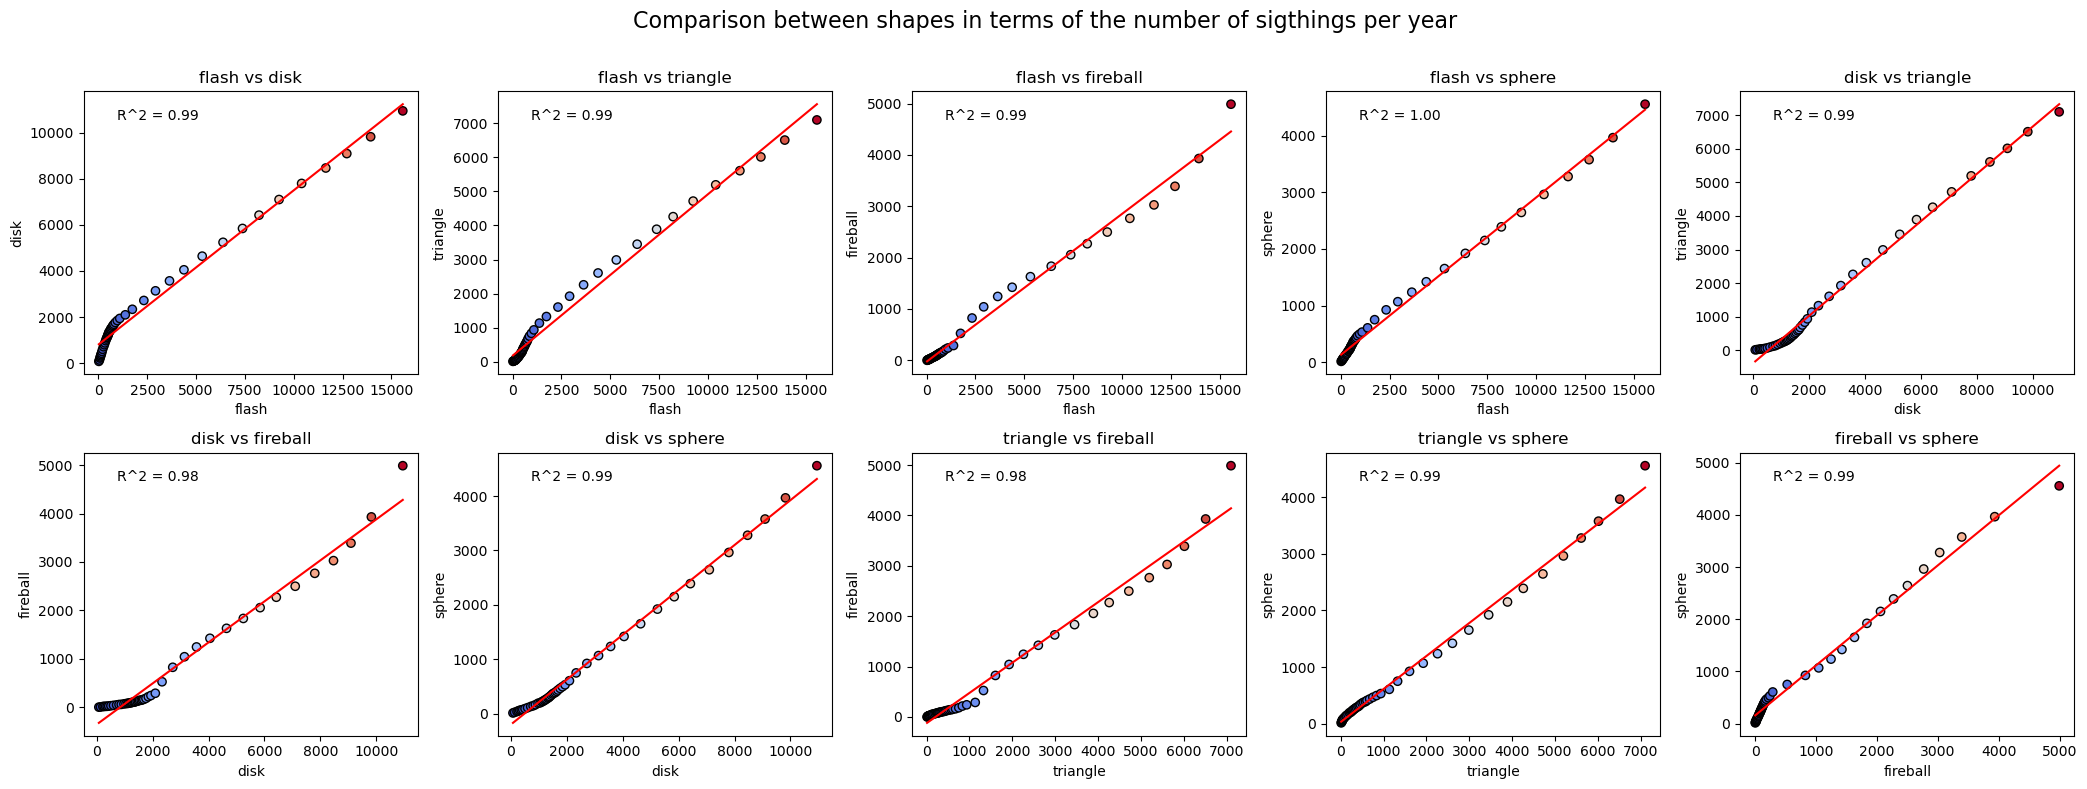

In [117]:
from itertools import combinations
from scipy.stats import linregress

focus_cat = ['flash', 'disk', 'triangle', 'fireball', 'sphere'] # categories with more than 5000 sightings
year_data = {}
rvalues = {}
small_dataset = dataset[dataset['datetime'].dt.year > 1965]  # even with filtering, figures have a lot of correlation
for shape in focus_cat:
    subset_data = small_dataset[small_dataset['shape'] == shape]
    year_data[shape] = subset_data['datetime'].dt.year.value_counts()
    year_data[shape] = year_data[shape].reindex(np.arange(subset_data['datetime'].dt.year.min(), subset_data['datetime'].dt.year.max()), fill_value=0)
    year_data[shape] = np.cumsum(year_data[shape])
fig, axs = plt.subplots(2, 5, figsize=(21, 8)) # A4 size
axs = axs.flatten()
for i, (shape1, shape2) in enumerate(combinations(focus_cat, 2)):
    slope, intercept, rvalue, _, _ = linregress(year_data[shape1], year_data[shape2])
    rvalues[(shape1, shape2)] = rvalue**2
    axs[i].plot(year_data[shape1], slope*year_data[shape1] + intercept, color='red')
    axs[i].scatter(year_data[shape1], year_data[shape2], c=year_data[shape1], cmap='coolwarm', edgecolor='k')
    axs[i].set_title(f"{shape1} vs {shape2}")
    axs[i].set_xlabel(shape1)
    axs[i].set_ylabel(shape2)
    axs[i].text(0.1, 0.9, f"R^2 = {rvalue**2:.2f}", transform=axs[i].transAxes)

plt.suptitle("Comparison between shapes in terms of the number of sigthings per year", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

The plot show potential correlation between different shape of UFOs during the years, starting from 1965. More in detail, each point represent the cumulative amount of sigthing for a shape in years. This comparison shows that more or less the proportion between shapes is constant during years. The only clear trend is that the disk and triangle shapes were more popular in first years, in respect to the other shapes.

Map of sigthings' location

In [118]:
from folium.plugins import HeatMap
from folium import Map
import matplotlib.pyplot as plt

map = Map(titles='Ufo Sightings')
heat_data = [[row['latitude'], row['longitude']] for _, row in dataset.iterrows()]
HeatMap(heat_data, radius=8, blur=4).add_to(map)
map

The map shows that the data are highly biased from the country of origin, in particual with a high amount of data in english-speaking countries. Curiosly, there aren't clusters in famous sigthing areas, such as Area 51 in Nevada, but they follow more or less the population distribution, with high clusters in big cities.

In [119]:
limits = [(50, -125), (50, -67), (25, -67), (25, -125)]
lat_step = 0.77 / 3
long_step = 1 / 3
# Create a grid of latitude and longitude values
latitudes = np.arange(limits[2][0], limits[0][0], lat_step)
longitudes = np.arange(limits[0][1], limits[1][1], long_step)
heat_area = np.zeros((len(latitudes), len(longitudes)))
# Create a grid of latitude and longitude values
for i, lat in enumerate(latitudes):
    for j, long in enumerate(longitudes):
        # Filter the dataset for the current grid cell
        mask = (dataset['latitude'] >= lat) & (dataset['latitude'] < lat + lat_step) & \
               (dataset['longitude'] >= long) & (dataset['longitude'] < long + long_step)
        heat_area[i, j] = len(dataset[mask])
# Print top 5 areas
sort_area = np.argsort(heat_area, axis=None)[-5:]
top_area = np.unravel_index(sort_area, heat_area.shape)
print("Top 5 areas with most UFO sightings:")
for i in range(5):
    print(f"Area: {limits[2][0]+lat_step*top_area[0][i]}, {limits[0][1]+long_step*top_area[1][i]} with {heat_area[top_area[0][i], top_area[1][i]]} sightings")

Top 5 areas with most UFO sightings:
Area: 33.21333333333333, -112.33333333333333 with 486.0 sightings
Area: 45.27666666666667, -123.0 with 508.0 sightings
Area: 33.983333333333334, -118.33333333333333 with 708.0 sightings
Area: 40.656666666666666, -74.33333333333334 with 741.0 sightings
Area: 47.586666666666666, -122.33333333333333 with 907.0 sightings


Correlation between geographical coordinates

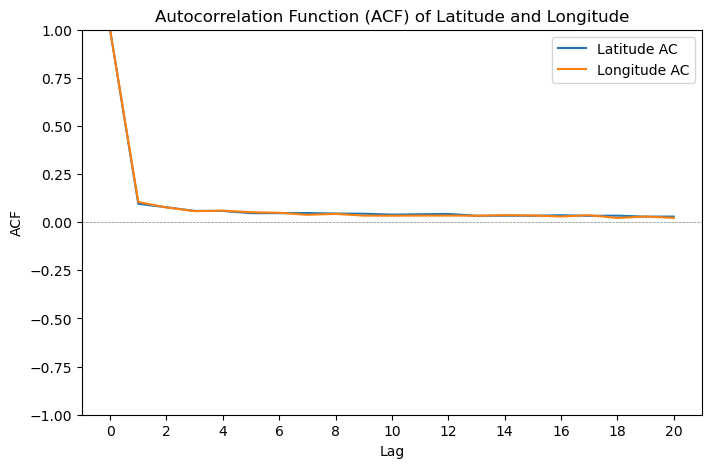

In [120]:
from statsmodels.tsa.stattools import acf
# try remove non US-Data
dataset = dataset[(dataset['latitude'] >= 25) & (dataset['latitude'] <= 50) &
                  (dataset['longitude'] >= -125) & (dataset['longitude'] <= -67)]
# remove data before 1998
dataset = dataset[dataset['datetime'].dt.year >= 1998].copy()
dataset.sort_values(by='datetime', inplace=True)
# check whith scipy.correlate2d
acf_lat = acf(dataset['latitude'], nlags=20)
acf_lon = acf(dataset['longitude'], nlags=20)
plt.figure(figsize=(8, 5))
plt.plot(acf_lat, label='Latitude AC')
plt.plot(acf_lon, label='Longitude AC')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.title('Autocorrelation Function (ACF) of Latitude and Longitude')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.ylim(-1, 1)
plt.xticks(ticks=np.arange(len(acf_lat), step=2), labels=np.arange(len(acf_lat), step=2))
plt.legend()
plt.show()

This plot shows the autocorrelation function between values of latitude and longitude. This function shows the level of autocorrelation (which is always between 1 and -1) between the location of a sigthing to the following one in cronological order (lag = 1), or after two (lag = 2) and so on. Excluding the trivial value of 1 for lag 0, there isn't a clear correlation for other values of lags, meaning that sigthing's location is mostly independent of the previous ones.